
<a id='seir-model'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Modelando o COVID-19 com Equações Diferenciais

## Conteúdo

- [Modelando o COVID-19 com Equações Diferenciais](#Modelando-o-COVID-19--com-Equações-Diferenciais)  
  - [Resumo](#Resumo)  
  - [O Modelo SEIR](#O-Modelo-SEIR)  
  - [Implementação](#Implementação)  
  - [Experimentos](#Experimentos)  
  - [Encerrando o Lockdown](#Encerrando-o-Lockdown)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

Co-autoria com Chris Rackauckas

Essa é uma versão do código do Julia para analizar a pandemia do COVID-19.

O propósito dessas notas é introduzir aos economistas a modelagem quantitativa da dinâmica das doenças infecciosas e a modelagem com equações diferenciais ordinárias.

Nessa aula, as dinâmicas são modeladas usando o modelo padão SEIR (Suscetível-Exposto-Infectado-Removido) 
de uma propagação de doença,  representado como um sistema de equações diferenciais ordinárias onde o número de agentes é grande e não há choques estocásticos exógenos.

A primeira parte do modelo é inspirada por:
*  Notas de [Andrew Atkeson](https://sites.google.com/site/andyatkeson/) e [NBER Working Paper No. 26867](https://www.nber.org/papers/w26867)
* [Estimating and Forecasting Disease Scenarios for COVID-19 with an SIR Model](https://www.nber.org/papers/w27335) de Andrew Atkeson, Karen Kopecky e Tao Zha
* [Estimating and Simulating a SIRD Model of COVID-19 for Many Countries, States, and Cities](https://www.nber.org/papers/w27128) de Jesús Fernández-Villaverde de Charles I. Jones
* Outras variações do modelo clássico SIR em Julia  [aqui](https://github.com/epirecipes/sir-julia).

Em seguida, estendemos este modelo determinístico [nessa aula](https://julia.quantecon.org/covid_sde.html) que se baseia neste modelo, adicionando choques agregados e compensações de políticas.

O interese está primordialmente em: 

- Estudar o impacto da supressão por meio do distanciamento social na disseminação da infecção.
- O número de infecções em um determinado momento (que determina se o sistema de saúde está sobrecarregado ou não); e  
- Por quanto tempo o número de casos pode ser adiado (esperançosamente até que uma vacina chegue).

### Configuração

In [1]:
using InstantiateFromURL
# optionally add arguments to force installation: instantiate = true, precompile = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.8.0")

In [2]:
using LinearAlgebra, Statistics, Random, SparseArrays

Além disso, exploraremos o pacote de [Equações Diferenciais Ordinárias](https://diffeq.sciml.ai/dev/tutorials/ode_example/) no [ecossistema de SciML](https://github.com/SciML/).

In [3]:
using OrdinaryDiffEq
using Parameters, Plots
gr(fmt=:png);

## O Modelo SEIR

Na versão do modelo SEIR, é presumido que todos os indivíduos da população sejam em um número finito de estados.

Os estados são: suscetível (S), exposto (E), infectado (I) e removido (R).

Esse tipo de [modelo compartimentado](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#Elaborations_on_the_basic_SIR_model)  tem muitas extensões (ex: SEIRS relaxa a imunidade vitalícia e permite transições de $ R \to S $).

Comentários:

- Aqueles no estado R, foram infectados e se recuperaram ou morreram. Observe que, em algumas variações, R pode referir-se apenas a agentes recuperados.
- Aqueles que se recuperaram e vivem, presume-se que adquiriram imunidade.
- Aqueles no grupo exposto ainda não são infecciosos.

### Mudanças no Estado Infectado

Dentro do modelo SEIR, o fluxo entre os estados segue o caminho $ S \to E \to I \to R $.

Nos vamos ignorar o nascimento e morte por não-covid durante o nosso horizonte de tempo, e assumimos um grande, constante, ao longo um número de indivíduos de tamanho $ N $.

Com isso, os simbolos $ S, E, I, R $ são usados para o número total de individuos e cada estado e em cada momento, e $ S(t) + E(t) + I(t) + R(t) = N $ para todo $ t $.

Uma vez que assumimos que $ N $ for grande, podemos usar uma aproximação contínua para o número de indivíduos em cada estado.

As transições entre esses estados são regidas pelas seguintes taxas:

- $ \beta(t) $ é chamada de *taxa de transição* ou *taxa de contato efetivo* (a taxa na qual os indivíduos se chocam com os outros e os expõem ao vírus).  
- $ \sigma $ é chamado de *taxa de infecção* (a taxa pela qual aqueles indivíduos expostos são infectados).  
- $ \gamma $ é chamado de *taxa de recuperação* ( taxa pela qual aqueles indivíduos infectados se recuperam ou morrem). 


A taxa $ \beta(t) $ é influenciada por ambas características da doença (por exemplo: o tipo e a duração do contato prolongado necessário para uma transmissão) e o comportatamento dos indivíduos (por exemplo: distanciamento social, higiene).

O modelo SEIR pode então ser escrito como:


<a id='equation-seir-system-big'></a>
$$
\begin{aligned}
     \frac{d S}{d t}  & = - \beta \, S \,  \frac{I}{N}
     \\
     \frac{d E}{d t}   & = \beta \, S \,   \frac{I}{N}  - \sigma E
     \\
      \frac{d I}{d t}  & = \sigma  E  - \gamma I
     \\
      \frac{d R}{d t}  & = \gamma  I
\end{aligned} \tag{1}
$$

Aqui, $ dy/dt $ epresenta a derivada de tempo para a variável particular.

O primeiro termo de [(1)](#equation-seir-system-big), $ -\beta \, S \,  \frac{I}{N} $,  é o fluxo de indivíduos que se deslocam de $ S \to E $, e destaca a dinâmica subjacente da epidemia.

- Indivíduos no estado suscetível (S) tem uma taxa $ \beta(t) $ de contatos prolongados com outros indivíduos onde a transmissão ocorreria se algum deles estivesse infectado. 
- Desses contatos, a fração $ \frac{I(t)}{N} $ será com agentes infectados (uma vez que assumimos que os indivíduos expostos ainda não são infecciosos)
- Finalmente, existem $ S(t) $ indivíduos suscetíveis.  
- O sinal indica que o produto desses termos é a saída do estado $ S $, e um influxo para o estado $ E $.  

### Número de Reprodução Básico

Se $ \beta $ for constante, então podemos definir  $ R_0 := \beta / \gamma $.  Esse é o famoso *número de reprodução básico*  para o modelo SEIR.  Veja [[HSW05]](https://julia.quantecon.org/../zreferences.html#heffernan2005perspectives) para mais detalhes.

Quando a taxa de transmissão varia no tempo, nós seguimos a notação em [[FVJ20]](https://julia.quantecon.org/../zreferences.html#nberw27128) e referimos a $ R_0(t) $ como uma versão do número básico de reprodução variante no tempo.

Analisar o sistema em [(1)](#equation-seir-system-big) fornece alguma intuição sobre a expressão $ R_0(t) := \beta(t) / \gamma $:

- As transições individuais do estado infectado para o removido ocorrem em uma taxa de Poisson $ \gamma $, o tempo esperado no estado infectado é  $ 1/\gamma $  
- Interações prolongadas ocorrem em uma taxa $ \beta $, então um novo indivíduo entrando no estado infectado irá potencialmente transmitir o vírus a uma média de $ R_0 = \beta \times 1 / \gamma $ para outros
- Em modelos mais complicados, veja [[HSW05]](https://julia.quantecon.org/../zreferences.html#heffernan2005perspectives) para uma definição formal de modelos arbitrários, e uma análise do papel de $ R_0 < 1 $.  


Perceba que a notação $ R_0 $ é padrão na literatura epidemiológica - embora confuso, um vez que $ R_0 $ não está relacionado com $ R $, o simbolo que representa o estado removido.  No restante da aula, evitaremos usar $ R $ para o estado removido.

Antes de resolver o modelo diretamente, fazemos algumas alterações em [(1)](#equation-seir-system-big)

- Parametrizamos novamente usando $ \beta(t) = \gamma R_0(t) $  
- Definimos a proporção de indivíduos em cada estado como $ s := S/N $ etc.  
- Dividimos cada equação em [(1)](#equation-seir-system-big) por $ N $, e escrevemos o sistemas de EDOs em termos das proporções.  



<a id='equation-seir-system'></a>
$$
\begin{aligned}
     \frac{d s}{d t}  & = - \gamma \, R_0 \, s \,  i
     \\
     \frac{d e}{d t}   & = \gamma \, R_0 \, s \,  i  - \sigma e
     \\
      \frac{d i}{d t}  & = \sigma  e  - \gamma i
     \\
      \frac{d r}{d t}  & = \gamma  i
\end{aligned} \tag{2}
$$

Uma vez que os estados forma uma partição, porderíamos reconstruir a fração “removida” da população como $ r = 1 - s - e - i $.  No entanto, mantê-la no sistema tornará a plotagem mais conveniente. 

### Implementação

Nós começamos por implementar uma versão simples deste modelo com uma constante $ R_0 $ e alguns valores de parâmetros de linha de base (discutiremos mais tarde).

Primeiro, defina o sistema de equações.

In [4]:
function F_simple(x, p, t; γ = 1/18, R₀ = 3.0, σ = 1/5.2)
    s, e, i, r = x

    return [-γ*R₀*s*i;       # ds/dt = -γR₀si
             γ*R₀*s*i -  σ*e;# de/dt =  γR₀si -σe
             σ*e - γ*i;      # di/dt =         σe -γi
                   γ*i;      # dr/dt =             γi
            ]
end

F_simple (generic function with 1 method)

Dado esse sistema, escolhemos uma condição inicial e um intervalo de tempo, e criamos um `ODEProblem` escapsulamento do sistema.

In [5]:
i_0 = 1E-7                  # 33 = 1E-7 * 330 milhões da população = inicialmente infectados
e_0 = 4.0 * i_0             # 132 = 1E-7 *330 milhões = inicialmente expostos
s_0 = 1.0 - i_0 - e_0
r_0 = 0.0
x_0 = [s_0, e_0, i_0, r_0]  # condição inicial

tspan = (0.0, 350.0)  # ≈ 350 dias
prob = ODEProblem(F_simple, x_0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: false
timespan: (0.0, 350.0)
u0: [0.9999995, 4.0e-7, 1.0e-7, 0.0]

Com issp, escolha um algoritmo de EDO e resolva o problema do valor inicial. Um bom algoritmo padrão para EDOs não-rigidos desse tipo podem ser `Tsit5()`, que é o método Tsitouras 5/4 Runge-Kutta.

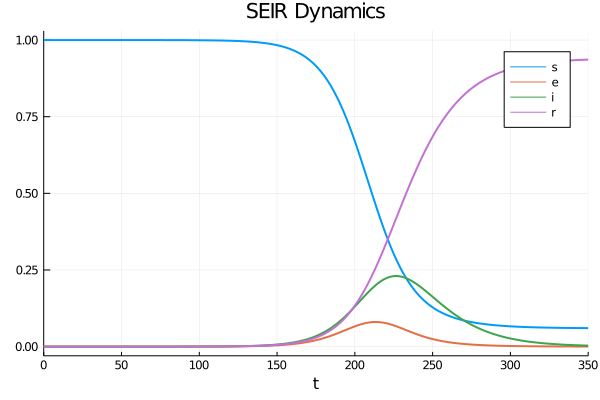

In [6]:
sol = solve(prob, Tsit5())
plot(sol, labels = ["s" "e" "i" "r"], title = "SEIR Dynamics", lw = 2)

Não fornecemos um conjunto de intervalos de tempo ou um intervalo de tempo do tamanho `dt` para resolver `solve`. Os solucionadores mais de EDO mais precisos e de alto desempenho apropriados para esse problema usam um intervalo de tempo adaptativo, alterando o tamanho do intervalo com base no grau da curvatura nas derivadas.

Ou, como uma visualização alternativas, as proporções em cada estado ao longo do tempo. 

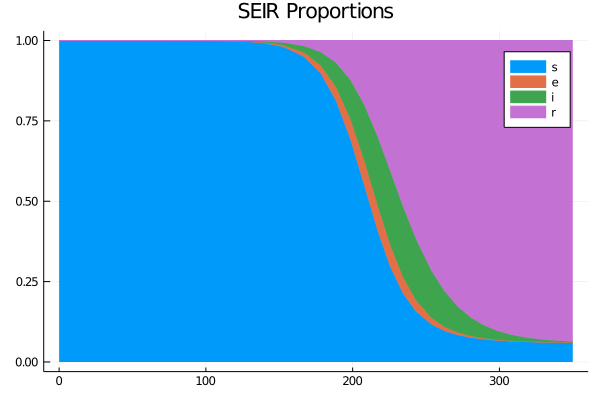

In [7]:
areaplot(sol.t, sol', labels = ["s" "e" "i" "r"], title = "SEIR Proportions")

 Enquanto mantém o sistema central de EDOs em $ (s, e, i, r) $, estenderemos o modelo básico para permitir alguns experimentos de política e cálculos de valores agregados.

### Estendendo o modelo

Em primeiro lugar, podemos considerar alguns cálculos adicionais, como o número de casos cumulativo (ou seja, todos aqueles que têm ou tiveram a infecção) como $ c = i + r $.  Diferenciando essa expressão e substituindo-a das derivadas do tempo de $ i(t) $ e $ r(t) $ dá $ \frac{d c}{d t} = \sigma e $.

Vamos supor que a taxa de transmissão segue um processo com reversão para um valor $ \bar{R}_0(t) $ que poderia ser influenciado pela política. A intuição é que mesmo que o alvo $ \bar{R}_0(t) $ foi alterado por meio de distanciamento social/etc., atrasos no comportamento e a implementação suavizaria a transição, onde $ \eta $ governa a velocidade que $ R_0(t) $ move-se em direção de $ \bar{R}_0(t) $.


<a id='equation-rode'></a>
$$
\begin{aligned}
\frac{d R_0}{d t} &= \eta (\bar{R}_0 - R_0)\\
\end{aligned} \tag{3}
$$

Finalmente, deixe $ \delta $ a taxa de mortalidade, que deixaremos constate.  As mortes cumulativas podem ser integradas através do fluxo $ \gamma i $ entrando no estado "Removido".

Defina o número cumulativo de mortes como $ D(t) $ com a proporção $ d(t) := D(t)/N $.


<a id='equation-mode'></a>
$$
\begin{aligned}\\
\frac{d}{d t}d(t) &= \delta \gamma  i
\end{aligned} \tag{4}
$$

Embora pudéssemos integrar as mortes dadas a solução ao modelo ex-post, é mais conveniente usar o integrador embutido no solucionador de EDOs. Ou seja, nós adicionamos $ \frac{d}{dt} d(t) $ ao inves de calcular $ d(t) = \int_0^t \delta \gamma\, i(\tau) d \tau $ ex-post.

Este é um truque comum ao resolver sistemas de EDOs. Embora equivalente em princípio ao uso do esquema de quadratura apropriado, isso se torna especialmente conveniente quando algoritmos de escalonamento de tempo adaptativos são usados para resolver os EDOs (ou seja, não há uma *grid* de tempo regular). Observe que, ao fazer isso $ d(0) = \int_0^0 \delta \gamma i(\tau) d \tau = 0 $ é a condição inicial.

O sistema [(2)](#equation-seir-system) e as equações suplementares podem ser escritas na forma vetorial $ x := [s, e, i, r, R₀, c, d] $ com tupla de parâmetros $ p := (\sigma, \gamma, \eta, \delta, \bar{R}_0(\cdot)) $

Note que nesses parâmetros, o número alvo de reprodução, $ \bar{R}_0(t) $, é uma função exógena.

O modelo é então $ \frac{d x}{d t} = F(x,t) $ onde:


<a id='equation-dfcv'></a>
$$
F(x,t) := \begin{bmatrix}
    -\gamma \, R_0 \, s \,  i
    \\
    \gamma \, R_0 \,  s \,  i  - \sigma e
    \\
    \sigma \, e  - \gamma i
    \\
    \gamma i
    \\
    \eta (\bar{R}_0(t) - R_0)
    \\
    \sigma e
    \\
    \delta \, \gamma \, i
\end{bmatrix} \tag{5}
$$

Observe que se $ \bar{R}_0(t) $ é invariante no tempo, então $ F(x, t) $ é invariante no tempo também.

### Parâmetros

Os parâmetros, $ \sigma, \delta, $ e $ \gamma $ devem ser pensados como parâmetros determinados a partir da biologia e da tecnologia médica e independentes de interações sociais.

Como na nota de Atkeson, definimos:

- $ \sigma = 1/5.2 $ para refletir um período de incubação média de 5.2 dias  
- $ \gamma = 1/18 $ para corresponder uma duração média da doença de 18 dias.  
- $ \bar{R}_0(t) = R_0(0) = 1.6 $ para corresponder um **número básico de reprodução** de 1.6, e inicialmente invariante no tempo.  
- $ \delta = 0.01 $ para uma taxa de mortalidade de 1%


Como iremos inicialmente considerar o caso em que $ R_0(0) = \bar{R}_0(0) $, o parâmetro $ \eta $ não influenciará o primeiro experimento.

## Implementação

Primeiro, construimos nosso $ F $ de [(5)](#equation-dfcv)

In [8]:
function F(x, p, t)
    s, e, i, r, R₀, c, d = x
    @unpack σ, γ, R̄₀, η, δ = p

    return [-γ*R₀*s*i;        # ds/dt
            γ*R₀*s*i -  σ*e;  # de/dt
            σ*e - γ*i;        # di/dt
            γ*i;              # dr/dt
            η*(R̄₀(t, p) - R₀);# dR₀/dt
            σ*e;              # dc/dt
            δ*γ*i;            # dd/dt
            ]
end;

Essa função pega o vetor `x` de estados no sistema e extrai os parâmetros fixados passados para objeto `p`.

A única parte confusa da notação é a `R̄₀(t, p)` que avalia o `p.R̄₀` neste momento (e também permite que dependa do parâmetro `p`).

### Parâmetros

Os parâmetros de linha de base são colocados em um gerador de tupla nomeada (consulte as aulas anteriores usando [Parameters.jl](https://github.com/mauro3/Parameters.jl)) com os valores padrões discutidos acima.

In [9]:
p_gen = @with_kw ( T = 550.0, γ = 1.0 / 18, σ = 1 / 5.2, η = 1.0 / 20,
                R₀_n = 1.6, δ = 0.01, N = 3.3E8,
                R̄₀ = (t, p) -> p.R₀_n);

Perceba que a função padrão $ \bar{R}_0(t) $ sempre igual a $ R_{0n} $ – um nível natural parametrizável de $ R_0 $ usado apenas pela função `R̄₀`. 

Definindo as condições iniciais, escolhemos um fixo $ s, i, e, r $, como também $ R_0(0) = R_{0n} $ e $ m(0) = 0.01 $

In [10]:
p = p_gen()  # use todos os parâmetros padrões

i_0 = 1E-7
e_0 = 4.0 * i_0
s_0 = 1.0 - i_0 - e_0

x_0 = [s_0, e_0, i_0, 0.0, p.R₀_n, 0.0, 0.0]
tspan = (0.0, p.T)
prob = ODEProblem(F, x_0, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: false
timespan: (0.0, 550.0)
u0: [0.9999995, 4.0e-7, 1.0e-7, 0.0, 1.6, 0.0, 0.0]

O `tspan` de `(0.0, p.T)` determina o $ t $ usado pelo solucionador. A escala de tempo deve ser consistente com a taxa de chegada das probabilidades de transição (ou seja, o $ \gamma, \sigma $ foram escolhidos com base em dados diários, então a unidade de $ t $ é um dia).

O período de tempo que investigamos será de 550 dias, ou cerca de 18 meses:

## Experimentos

Vamos executar alguns experimentos usando este código.

In [11]:
sol = solve(prob, Tsit5())
@show length(sol.t);

length(sol.t) = 45


Vemos que o escalonamento de tempo adaptativo usou aproximadamente 45 intervalos de tempo para resolver esse problema com a precisão desejada. A avaliação do solucionador em pontos fora dessas etapas de tempo usa um interpolador consistente com a solução para a EDO.

Embora possa parecer que 45 intervalos de tempo são extremamente pequenos para esse intervalo, para grande parte do $ t $, as funções são muito planas - e, portanto, os algoritmos de passo de tempo adaptativos podem se mover rapidamente e interpolar com precisão.

O objeto de soluçãom foi [construido em](https://docs.sciml.ai/stable/basics/plot/) suporte de plotagem.

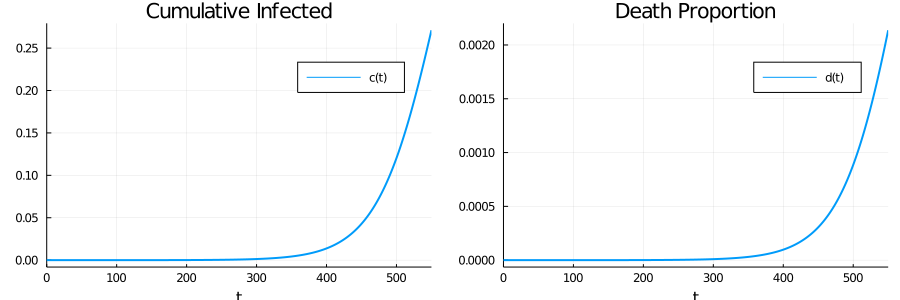

In [12]:
plot(sol, vars = [6, 7], label = ["c(t)" "d(t)"], lw = 2,
     title = ["Cumulative Infected" "Death Proportion"],
     layout = (1,2), size = (900, 300))

Mais alguns comentários:

- Se você quiser garantir que haja pontos específicos que a etapa adaptativa no tempo deve incluir (por exemplo, em descontinuidades conhecidas), use [tstops](https://diffeq.sciml.ai/stable/basics/common_solver_opts/#Output-Control-1).  
- Os gráficos integrados para as soluções fornecem todos os [atributos](https://docs.juliaplots.org/latest/tutorial/) em 
[Plots.jl](https://github.com/JuliaPlots/Plots.jl).  
- Veja [aqui](https://docs.sciml.ai/stable/basics/solution/) os detalhes sobre como analisar a solução extrair a saída. 

### Experimento 1: O Caso de reprodução constante

Vamos começar com o caso em que $ \bar{R}_0(t) = R_{0n} $ é constante.

Calculamos a trajetória de tempo das pessoas infectadas sob diferentes suposições de $ R_{0n} $:

In [13]:
R₀_n_vals = range(1.6, 3.0, length = 6)
sols = [solve(ODEProblem(F, x_0, tspan, p_gen(R₀_n = R₀_n)),
              Tsit5(), saveat=0.5) for R₀_n in R₀_n_vals];

Aqui, escolhemos `saveat=0.5` para obter soluções com espaçamento uniforme a cada `0.5`.

Alterar os pontos salvos é apenas uma questão de armazenamento/interpolação e não altera o intervalo de tempo adaptativo dos solucionadores.

Vamos representar os casos atuais como uma fração da população.

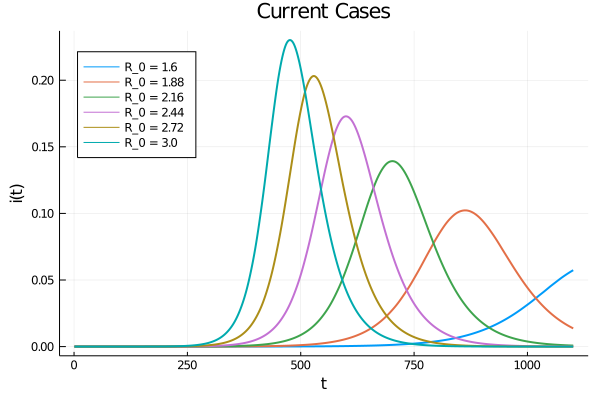

In [14]:
labels = permutedims(["R_0 = $r" for r in R₀_n_vals])
infecteds = [sol[3,:] for sol in sols]
plot(infecteds, label=labels, legend=:topleft, lw = 2, xlabel = "t",
     ylabel = "i(t)", title = "Current Cases")

Como esperado, taxas de transmissão efetivas mais baixas retratam o pico das infecções.

Isso também leva a um pico mais baixo nos casos atuais.

Aqui estão os casos cumulativos, como uma fração da população:

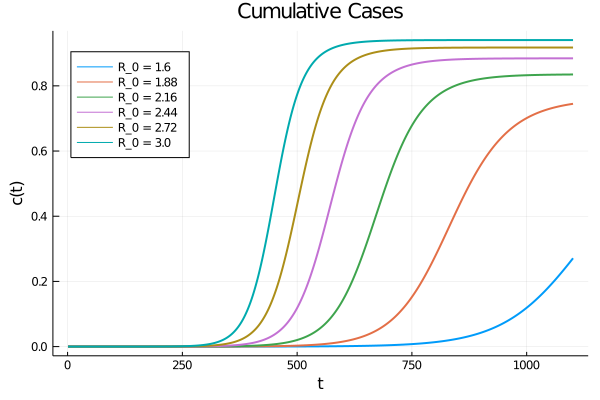

In [15]:
cumulative_infected = [sol[6,:] for sol in sols]
plot(cumulative_infected, label=labels ,legend=:topleft, lw = 2, xlabel = "t",
     ylabel = "c(t)", title = "Cumulative Cases")

### Experimento 2: Mudando a Mitigação

Vejamos um cenário onde a mitigação (por exemplo, distânciamento social) é sucessivamente imposta, mas a meta (mantendo $ R_{0n} $) é fixa.

Para fazer isso, iniciamos com $ R_0(0) \neq R_{0n} $ e examinamos a dinâmica usando a EDO $ \frac{d R_0}{d t} = \eta (R_{0n} - R_0) $.

Nesse caso simples, onde $ \bar{R}_0(t) = R_{0n} $ é independente do estado, a solução para a EDO dada uma condição inicial é $ R_0(t) = R_0(0) e^{-\eta t} + R_{0n}(1 - e^{-\eta t}) $

Examinaremos esse caso onde $ R_0(0) = 3 $ e então cai para $ R_{0n} = 1.6 $ devido à adoção progressiva de medidas de mitigação mais rígidas.

O parâmetro `η` controla a taxa, ou as velocidade que as retrições são impostas.

Consideramos várias taxas diferentes:

In [16]:
η_vals = [1/5, 1/10, 1/20, 1/50, 1/100]
labels = permutedims(["eta = $η" for η in η_vals]);

Vamos calcular o tempo de pessoas infectadas, casos atuais e mortalidade.

In [17]:
x_0 = [s_0, e_0, i_0, 0.0, 3.0, 0.0, 0.0]
sols = [solve(ODEProblem(F, x_0, tspan, p_gen(η=η)), Tsit5(), saveat=0.5) for η in η_vals];

Próximo, plote o $ R_0 $ ao longo do tempo:

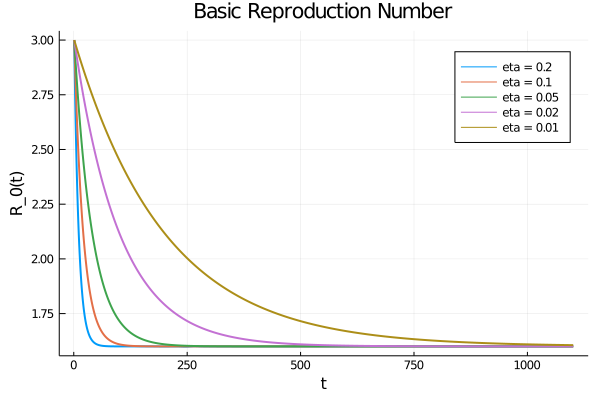

In [18]:
Rs = [sol[5,:] for sol in sols]
plot(Rs, label=labels, legend=:topright, lw = 2, xlabel = "t",
     ylabel = "R_0(t)", title = "Basic Reproduction Number")

Agora vamos representar graficamente o número de pessoas infectadas e o número cumulativo de pessoas infectadas: 

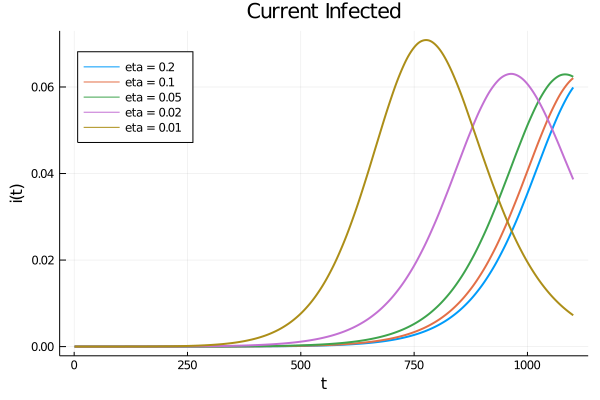

In [19]:
infecteds = [sol[3,:] for sol in sols]
plot(infecteds, label=labels, legend=:topleft, lw = 2, xlabel = "t",
     ylabel = "i(t)", title = "Current Infected")

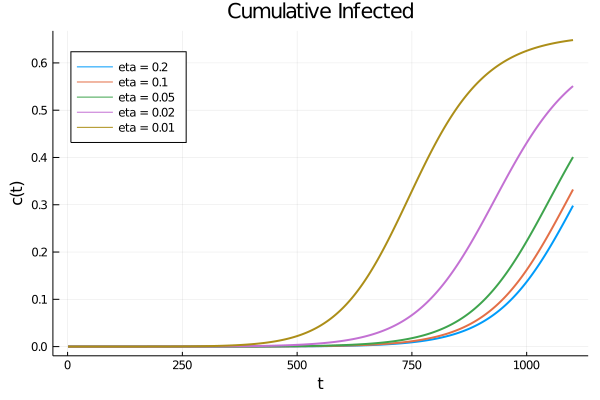

In [20]:
cumulative_infected = [sol[6,:] for sol in sols]
plot(cumulative_infected, label=labels ,legend=:topleft, lw = 2, xlabel = "t",
     ylabel = "c(t)", title = "Cumulative Infected")

## Encerrando o Lockdown

O que vem as seguir foi inspirado por [resultados adicionais](https://drive.google.com/file/d/1uS7n-7zq5gfSgrL3S0HByExmpq4Bn3oh/view) de Andrew Atkeson sobre o tempo de levantamento do *Lockdown*.

Considere esses dois cenários de mitigação:

1. Escolha $ \bar{R}_0(t) $ para marcar $ R_0(t) = 0.5 $ para 30 dias e então $ R_0(t) = 2 $ para os 17 meses restantes. Isso corresponde ao levantamento do *Lockdown* em 30 dias.  
1. $ R_0(t) = 0.5 $ para 120 dias e então $ R_0(t) = 2 $ para os 14 meses restantes. Isso corresponde ao levantamento do *Lockdown* em 4 meses.


Para ambos, escolhemos um grande $ \eta $ focando no caso em que mudanças rápidas na política de *Lockdown* permanecem viáveis.

Os parâmetros aqui considerados iniciam o modelo com 25.000 infecções ativas e 75.000 agentes já expostos ao vírus e, portanto, em breve contagiosos.

In [21]:
R₀_L = 0.5  # lockdown
R̄₀_lift_early(t, p) = t < 30.0 ? R₀_L : 2.0
R̄₀_lift_late(t, p) = t < 120.0 ? R₀_L : 2.0
p_early = p_gen(R̄₀= R̄₀_lift_early, η = 10.0)
p_late = p_gen(R̄₀= R̄₀_lift_late, η = 10.0)


# Condições iniciais
i_0 = 25000 / p_early.N
e_0 = 75000 / p_early.N
s_0 = 1.0 - i_0 - e_0

x_0 = [s_0, e_0, i_0, 0.0, R₀_L, 0.0, 0.0] # inicio do lockdown

# crie dois problemas, com o rápido movimento de R₀(t) no sentido de R̄₀(t)
prob_early = ODEProblem(F, x_0, tspan, p_early)
prob_late = ODEProblem(F, x_0, tspan, p_late)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: false
timespan: (0.0, 550.0)
u0: [0.9996969696969696, 0.00022727272727272727, 7.575757575757576e-5, 0.0, 0.5, 0.0, 0.0]

Ao contrário dos exemplos anteriores, as funções $ \bar{R}_0(t) $  têm descontinuidades que podem ocorrer. Podemos melhorar a eficiência dos métodos de escalonamento de tempo adaptativos dizendo-lhes para incluir uma etapa exatamente nesses pontos usando `tstops`

Vamos calcular os caminhos:

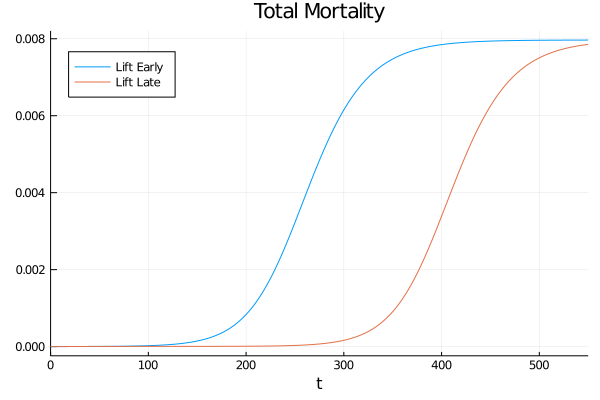

In [22]:
sol_early = solve(prob_early, Tsit5(), tstops = [30.0, 120.0])
sol_late = solve(prob_late, Tsit5(), tstops = [30.0, 120.0])
plot(sol_early, vars = [7], title = "Total Mortality", label = "Lift Early", legend = :topleft)
plot!(sol_late, vars = [7], label = "Lift Late")

Em seguida, vamos examinar as mortes diárias, $ \frac{d D(t)}{dt} = N \delta \gamma i(t) $.

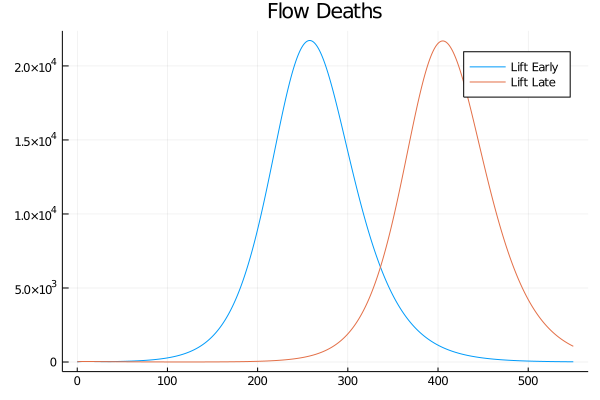

In [23]:
flow_deaths(sol, p) = p.N * p.δ * p.γ * sol[3,:]

plot(sol_early.t, flow_deaths(sol_early, p_early), title = "Flow Deaths", label = "Lift Early")
plot!(sol_late.t, flow_deaths(sol_late, p_late), label = "Lift Late")

Empurrar o pico da curva ainda mais para o futuro pode reduzir as mortes cumulativas se uma vacina for encontrada, ou permitir que as autoridades de saúde suavizem melhor o número de casos.

### Aleatoriedade

Apesar de sua riqueza, o modelo acima é totalmente determinístico. A política $ \bar{R}_0(t) $ pode mudar com o tempo, mas apenas de maneiras previsíveis.

Uma forma pela qual a aleatoriedade pode levar a flutuações agregadas é a granularidade que surge por meio da discrição dos indivíduos. Nesse tópico, a conexão entre SDEs e as equações de Langevin tipicamente usadas na aproximação de reações químicas em meios bem misturados, é explorado em outras aulas sobre cadeias de Markov de tempo contínuo.

Em vez disso, na [próxima aula](https://julia.quantecon.org/covid_sde.html), vamos nos concentrar na aleatoriedade que vem de mudanças agregadas no comportamento ou política.